In [1]:
!curl -L "https://universe.roboflow.com/ds/fqlZIhYGOg?key=3F6f6AKkc8" > roboflow.zip;
!md data && cd data
!unzip /content/roboflow.zip
!rm /content/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   1834      0 --:--:-- --:--:-- --:--:--  1830
100  136M  100  136M    0     0  17.3M      0  0:00:07  0:00:07 --:--:-- 22.9M
/bin/bash: md: command not found
Archive:  /content/roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/fruit-vegetable.tfrecord  
 extracting: test/fruit-vegetable_label_map.pbtxt  
   creating: train/
 extracting: train/fruit-vegetable.tfrecord  
 extracting: train/fruit-vegetable_label_map.pbtxt  
   creating: valid/
 extracting: valid/fruit-vegetable.tfrecord  
 extracting: valid/fruit-vegetable_label_map.pbtxt  


In [2]:
!pip install tflite_model_maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 10.1 MB/s 
     |████████████████████████████████| 60.8 MB 96 kB/s 
     |████████████████████████████████| 1.3 MB 45.3 MB/s 
     |████████████████████████████████| 77 kB 4.4 MB/s 
     |████████████████████████████████| 840 kB 50.0 MB/s 
     |████████████████████████████████| 238 kB 74.8 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 128 kB 55.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.3 MB/s 
     |████████████████████████████████| 10.9 MB 69.6 MB/s 
     |████████████████████████████████| 3.4 MB 62.5 MB/s 
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 352 kB 67.7 MB/s 
     |████████████████████████████████| 5.8 MB 56.4 MB/s 
     |█████████████████████████████

In [3]:
from tflite_model_maker import object_detector as tfobm
from tflite_model_maker import model_spec as ms

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
class_map = read_label_map("/content/train/fruit-vegetable_label_map.pbtxt")

In [6]:
train_dat = tfobm.DataLoader("/content/train/*.tfrecord", 800, class_map, None)
val_dat = tfobm.DataLoader("/content/valid/*.tfrecord", 200, class_map, None)

In [8]:
spec = ms.get('efficientdet_lite2')

In [9]:
model = tfobm.create(train_dat, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=val_dat)

Epoch 1/50
100/100 [==============================] - 101s 554ms/step - det_loss: 1.6793 - cls_loss: 1.2797 - box_loss: 0.0080 - reg_l2_loss: 0.0789 - loss: 1.7582 - learning_rate: 0.0090 - gradient_norm: 1.8229 - val_det_loss: 1.5421 - val_cls_loss: 1.0711 - val_box_loss: 0.0094 - val_reg_l2_loss: 0.0789 - val_loss: 1.6211
Epoch 2/50
100/100 [==============================] - 55s 550ms/step - det_loss: 1.2493 - cls_loss: 1.0375 - box_loss: 0.0042 - reg_l2_loss: 0.0790 - loss: 1.3283 - learning_rate: 0.0100 - gradient_norm: 2.9748 - val_det_loss: 1.1171 - val_cls_loss: 0.8394 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0791 - val_loss: 1.1962
Epoch 3/50
100/100 [==============================] - 53s 532ms/step - det_loss: 0.9582 - cls_loss: 0.7750 - box_loss: 0.0037 - reg_l2_loss: 0.0792 - loss: 1.0374 - learning_rate: 0.0099 - gradient_norm: 2.8923 - val_det_loss: 1.6627 - val_cls_loss: 1.1957 - val_box_loss: 0.0093 - val_reg_l2_loss: 0.0793 - val_loss: 1.7420
Epoch 4/50
100/100 [====

In [10]:
model.export(export_dir='/content')

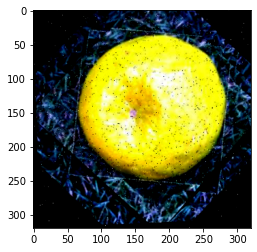

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(next(iter(train_dat.gen_dataset(spec).take(1)))[0][7])

In [ ]:
model.evaluate(val_dat)

In [4]:
import cv2
import tensorflow as tf
import numpy as np

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * 20
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}

    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip().rstrip(","))
            elif "display_name" in line:
                item_name = line.split(" ")[-1].replace("\"", " ").strip()
            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

label_map = read_label_map("/content/train/fruit-vegetable_label_map.pbtxt")
for label_id, label_name in label_map.items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8


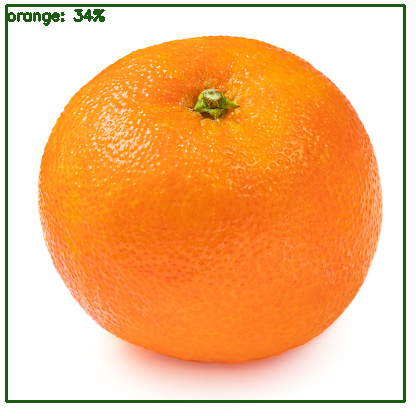

In [11]:
DETECTION_THRESHOLD = 0.1

TEMP_FILE = '/content/test.jpg'

im = Image.open(TEMP_FILE)
im.thumbnail((416, 416), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


In [12]:
from google.colab import files
files.download("/content/model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>